In [77]:
import sys,os,copy,glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
from smodels.tools.physicsUnits import fb
from smodels.tools import runtime
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats,integrate,optimize,special
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
sns.set_palette(sns.color_palette("Paired"))

### Define number of observed, expected and observed events:

In [96]:
nobs = 110
nExp = 30.0
nExpErr = 40.0
nsig = 1 #Keep it at one in order to compare the likelihoods

### Compute exact  likelihood

In [97]:
def likelihood(mu,nsig,nExp,nExpErr,nobs):
    """Marginalized likelihood for mu"""
    
    def integrand(nbg):
        nTot = nbg + mu*nsig
        nErr = nExpErr
        p = stats.poisson.pmf(k=nobs,mu=nTot)*stats.norm.pdf(x=nbg,loc=nExp,scale=nErr)
        return p
        
    #Marginalize over the background uncertainty
    result = integrate.quad(integrand, 0, max(2*(nobs-nExp),nExp+5*nExpErr))
    
    return result[0]

def p(mu,nsig,nExp,nExpErr,nobs):
    """Integral of the likelihood from zero to mu"""
    
    result = integrate.quad(likelihood, 0, mu,args=(nsig,nExp,nExpErr,nobs,))
    return result[0]

### Compute observed and expected upper limits

In [98]:
norm = p((nobs-nExp)+5*nExpErr,nsig,nExp,nExpErr,nobs)
ULobs = optimize.brentq(lambda x: p(x,nsig,nExp,nExpErr,nobs)/norm - 0.95,
                        0,2*(nobs-nExp+3*nExpErr))

normExp = p(5*nExp,nsig,nExp,nExpErr,nExp)
ULexp = optimize.brentq(lambda x: p(x,nsig,nExp,nExpErr,nExp)/normExp - 0.95,
                        0,2*(3*nExpErr))

In [99]:
print(r'Nobs = %1.2f, Nbg = %1.2f +- %1.2f, Nsig < %1.2f, Nsig (expected) < %1.2f'
     %(nobs,nExp,nExpErr,ULobs,ULexp))

Nobs = 110.00, Nbg = 30.00 +- 40.00, Nsig < 110.47, Nsig (expected) < 32.02


### Define approximate likelihood (from limits)

In [100]:
sigma = ULexp/1.96
mu0 = optimize.brentq(lambda x: 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) 
                        +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma))),
                       0,2*(nobs-nExp+3*nExpErr))

def llhdFromLimits(mu,mu0,sigma):
    return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)

In [101]:
muvals = np.linspace(0,nobs-nExp+4*nExpErr,100)

In [102]:
llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])

In [103]:
mumax = llhds[np.argmax(llhds[:,1])][0]
mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

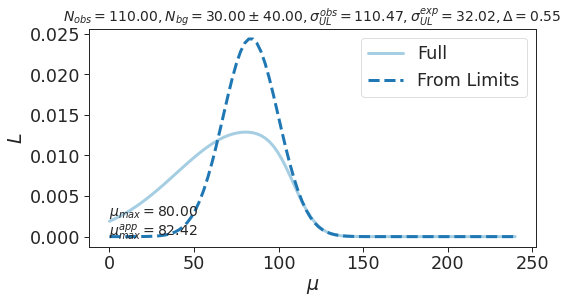

In [104]:
f = plt.figure(figsize=(8,4))
plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3)
plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$L$')
plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$' 
          %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
plt.show()

In [105]:
ULobs, ULexp

(110.47481923245013, 32.018181632468114)

## Capping at 3 sigmas

In [88]:
if ULobs > 2.53*ULexp: ## capping at 3 sigma
    ULobs = 2.53 * ULexp 

In [89]:
ULobs, ULexp

(30.212498353976887, 29.61063603292933)

In [90]:
sigma = ULexp/1.96
mu0 = optimize.brentq(lambda x: 0.95- (special.erf((ULobs-x)/(np.sqrt(2)*sigma)) 
                        +  special.erf(x/(np.sqrt(2)*sigma)))/(1+special.erf(x/(np.sqrt(2)*sigma))),
                       0,2*(nobs-nExp+3*nExpErr))

def llhdFromLimits(mu,mu0,sigma):
    return stats.norm.pdf(x=mu,loc=mu0,scale=sigma)

normLim = 1 - stats.norm.cdf(0,loc=mu0,scale=sigma)

In [91]:
muvals = np.linspace(0,nobs-nExp+4*nExpErr,100)

In [92]:
llhds = np.array([[mu,likelihood(mu,nsig,nExp,nExpErr,nobs)/norm] for mu in muvals])
llhdsApp = np.array([[mu,llhdFromLimits(mu,mu0,sigma)/normLim] for mu in muvals])

In [93]:
mumax = llhds[np.argmax(llhds[:,1])][0]
mumaxApp = llhdsApp[np.argmax(llhdsApp[:,1])][0]

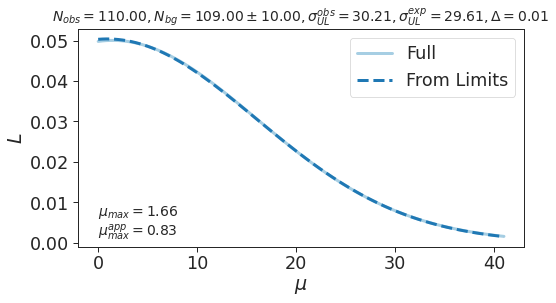

In [94]:
f = plt.figure(figsize=(8,4))
plt.plot(llhds[:,0],llhds[:,1],label='Full',linewidth=3)
plt.plot(llhdsApp[:,0],llhdsApp[:,1],label='From Limits',linestyle='--',linewidth=3)
plt.legend()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$L$')
plt.text(0,llhdsApp[:,1].min(),'$\mu_{max} = %1.2f$\n$\mu_{max}^{app} = %1.2f$' %(mumax,mumaxApp),fontsize=14)
plt.title(r'$N_{obs} = %1.2f, N_{bg} = %1.2f \pm %1.2f, \sigma_{UL}^{obs} = %1.2f, \sigma_{UL}^{exp} = %1.2f, \Delta = %1.2f$' 
          %(nobs,nExp,nExpErr,ULobs,ULexp,abs(ULobs-ULexp)/(ULobs+ULexp)),fontsize=14)
plt.show()